In [1]:
import pandas as pd
import numpy as np

# Define the file path and sheet name
file_path = '/Users/alesarabandi/Documents/Fin_Market/Stoxx 600 Originale.xlsm' # Adjust path if necessary
sheet_name = 'Price daily'

# Load the data, specifying header=1 to use the second row as column names
try:
    df_prices = pd.read_excel(file_path, sheet_name=sheet_name, header=1)
    print(f"Successfully loaded '{sheet_name}' from '{file_path}'.")
except Exception as e:
    print(f"Error loading data: {e}")
    df_prices = None

if df_prices is not None:
    # Rename first column to 'Date' and convert to datetime
    df_prices.rename(columns={df_prices.columns[0]: 'Date'}, inplace=True)
    df_prices['Date'] = pd.to_datetime(df_prices['Date'])
    
    # Set date as index
    df_prices.set_index('Date', inplace=True)
    
    # Convert all values to numeric (coerce errors)
    df_prices = df_prices.apply(pd.to_numeric, errors='coerce')
    
    # Drop any columns that are fully NaN
    df_prices.dropna(axis=1, how='all', inplace=True)
    
    print("\n--- Preview of df_prices (Cleaned Prices) ---")
    print(df_prices.head())
    print(f"Shape of df_prices: {df_prices.shape}")
    
    # Compute daily log returns
    df_returns = np.log(df_prices / df_prices.shift(1))
    
    print("\n--- Preview of df_returns (Daily Log Returns) ---")
    print(df_returns.head())
    print(f"Shape of df_returns: {df_returns.shape}")
    
    # Resample daily returns to monthly returns (summing log returns)
    monthly_returns = df_returns.resample('M').sum()
    
    print("\n--- Preview of monthly_returns (Monthly Log Returns) ---")
    print(monthly_returns.head())
    print(f"Shape of monthly_returns: {monthly_returns.shape}")
    
else:
    print("Data loading failed. Please check file_path and sheet_name.")

Successfully loaded 'Price daily' from '/Users/alesarabandi/Documents/Fin_Market/Stoxx 600 Originale.xlsm'.

--- Preview of df_prices (Cleaned Prices) ---
             BP PLC  Vodafone Group PLC  GlaxoSmithKline PLC  \
Date                                                           
2002-01-01  8.72226             4.18054             28.14317   
2002-01-02  8.48942             4.02933             27.33882   
2002-01-03  8.56310             4.18204             28.10616   
2002-01-04  8.59106             4.22866             27.72348   
2002-01-07  8.55836             4.16140             27.40609   

            HSBC Holdings PLC  TOTAL SA  Novartis AG  \
Date                                                   
2002-01-01           11.47251   39.5749     40.52545   
2002-01-02           11.29900   38.8841     39.68591   
2002-01-03           11.59081   39.3282     38.92710   
2002-01-04           11.78465   39.4022     38.62622   
2002-01-07           11.66068   38.9087     38.80380   

   

/var/folders/gm/6dd1_bfn3754c2866shkmkgc0000gn/T/ipykernel_9344/2399012523.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df_returns.resample('M').sum()


In [2]:
# --- TSM Parameters ---
tsm_lookback_months = 12 # Looking back 12 months for Time-Series Momentum

# --- Calculate Time-Series Momentum (TSM) ---
# TSM is often calculated as the sum (or average) of returns over a lookback window.
# Since we're using log returns, summing them is appropriate.
# We apply this rolling sum to each column (stock) in monthly_returns.
df_tsm = monthly_returns.rolling(
    window=tsm_lookback_months,
    min_periods=int(tsm_lookback_months * 0.75) # Require at least 75% of data for a valid TSM
).sum()

# Drop rows where all TSM values are NaN (i.e., too early in the history for any stock to have TSM)
df_tsm = df_tsm.dropna(how='all')

print(f"\n--- Preview of df_tsm (Time-Series Momentum for {tsm_lookback_months} Months) ---")
print(df_tsm.head())
print("\n--- df_tsm Tail ---")
print(df_tsm.tail())
print(f"\nShape of df_tsm: {df_tsm.shape}")
print(f"Number of NaNs in df_tsm after dropping all-NaN rows: {df_tsm.isnull().sum().sum()}")


--- Preview of df_tsm (Time-Series Momentum for 12 Months) ---
              BP PLC  Vodafone Group PLC  GlaxoSmithKline PLC  \
Date                                                            
2002-09-30 -0.255837           -0.818492            -0.364584   
2002-10-31 -0.296706           -0.591735            -0.377683   
2002-11-30 -0.286500           -0.430327            -0.402030   
2002-12-31 -0.286891           -0.525247            -0.431713   
2003-01-31 -0.430667           -0.403988            -0.459418   

            HSBC Holdings PLC  TOTAL SA  Novartis AG  \
Date                                                   
2002-09-30          -0.251916 -0.185820    -0.013806   
2002-10-31          -0.156473 -0.142478    -0.051370   
2002-11-30          -0.098263 -0.171656    -0.080094   
2002-12-31          -0.223757 -0.164282    -0.155120   
2003-01-31          -0.298330 -0.260035    -0.154953   

            Royal Dutch Petroleum Co  Nestle SA  Nokia OYJ  \
Date                     

In [3]:
# --- CSM Parameters ---
csm_lookback_months = 6 # Looking back 6 months for Cross-Sectional Momentum

# --- Calculate Cross-Sectional Momentum (CSM) ---
# CSM is also calculated as a rolling sum of log returns over a lookback window.
# The key difference in its *application* is that it's used for cross-sectional ranking.
df_csm = monthly_returns.rolling(
    window=csm_lookback_months,
    min_periods=int(csm_lookback_months * 0.75) # Require at least 75% of data for a valid CSM
).sum()

# Drop rows where all CSM values are NaN
df_csm = df_csm.dropna(how='all')

print(f"\n--- Preview of df_csm (Cross-Sectional Momentum for {csm_lookback_months} Months) ---")
print(df_csm.head())
print("\n--- df_csm Tail ---")
print(df_csm.tail())
print(f"\nShape of df_csm: {df_csm.shape}")
print(f"Number of NaNs in df_csm after dropping all-NaN rows: {df_csm.isnull().sum().sum()}")


--- Preview of df_csm (Cross-Sectional Momentum for 6 Months) ---
              BP PLC  Vodafone Group PLC  GlaxoSmithKline PLC  \
Date                                                            
2002-04-30  0.081820           -0.494543            -0.047500   
2002-05-31  0.051170           -0.594462            -0.244788   
2002-06-30 -0.024864           -0.747960            -0.251022   
2002-07-31 -0.126281           -0.479408            -0.335205   
2002-08-31 -0.184868           -0.289549            -0.382227   

            HSBC Holdings PLC  TOTAL SA  Novartis AG  \
Date                                                   
2002-04-30          -0.005301  0.047484     0.138383   
2002-05-31           0.013106  0.039724     0.124754   
2002-06-30          -0.122232  0.024632     0.093958   
2002-07-31          -0.104550 -0.099309     0.043742   
2002-08-31          -0.082227 -0.155722    -0.058550   

            Royal Dutch Petroleum Co  Nestle SA  Nokia OYJ  \
Date                  

Selected 195 rebalancing dates based on frequency 'M'.
True strategy start date (based on signal availability): 2002-09-30
First 5 rebalancing dates: [Timestamp('2002-09-30 00:00:00'), Timestamp('2002-10-31 00:00:00'), Timestamp('2002-11-30 00:00:00'), Timestamp('2002-12-31 00:00:00'), Timestamp('2003-01-31 00:00:00')]
Last 5 rebalancing dates: [Timestamp('2018-07-31 00:00:00'), Timestamp('2018-08-31 00:00:00'), Timestamp('2018-09-30 00:00:00'), Timestamp('2018-10-31 00:00:00'), Timestamp('2018-11-30 00:00:00')]

--- Portfolio Holdings at Each Rebalance (First few periods) ---
  2002-09-30: Selected 30 stocks:
    ['Lundin Petroleum AB', 'Laser Holdings Ltd', 'Zimmer Schweiz Holdings GmbH', 'MS Amlin PLC', 'D/S Norden A/S', 'Banque Nationale de Belgique', 'Randgold Resources Ltd', 'CEZ AS', 'Givaudan SA', 'Givaudan SA.1', 'Bourbon Corp', 'Caisse Regionale de Credit Agricole Mutu', 'Carlsberg A/S', 'Premier Oil PLC', 'OPAP SA', 'Cia Espanola de Petroleos SAU', 'ArcelorMittal', 'Komercni

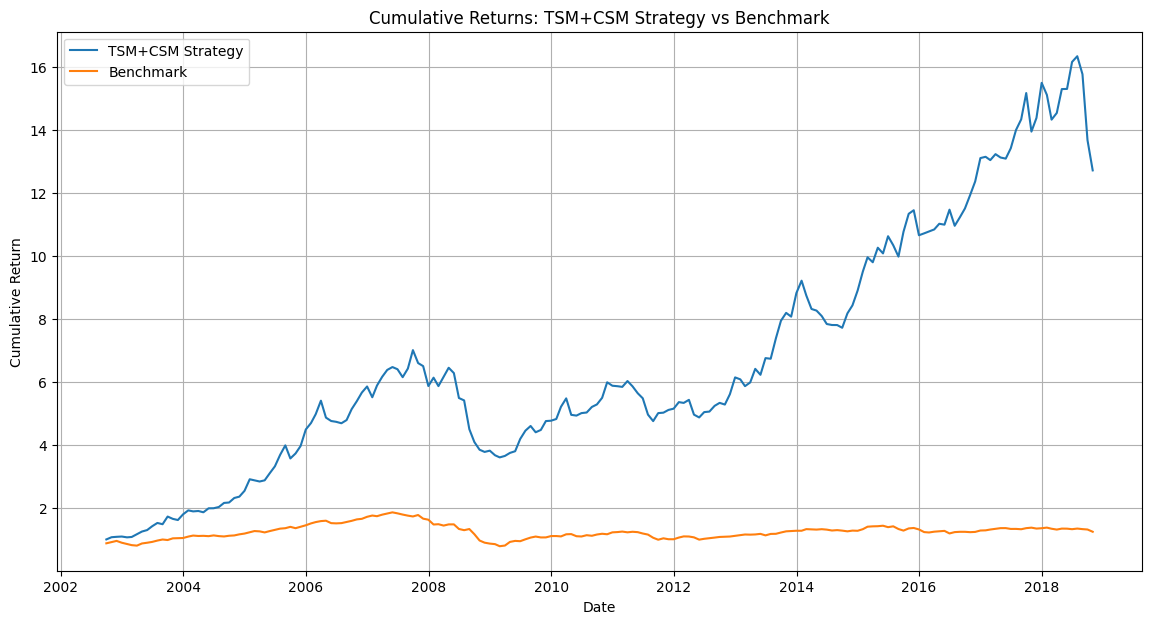

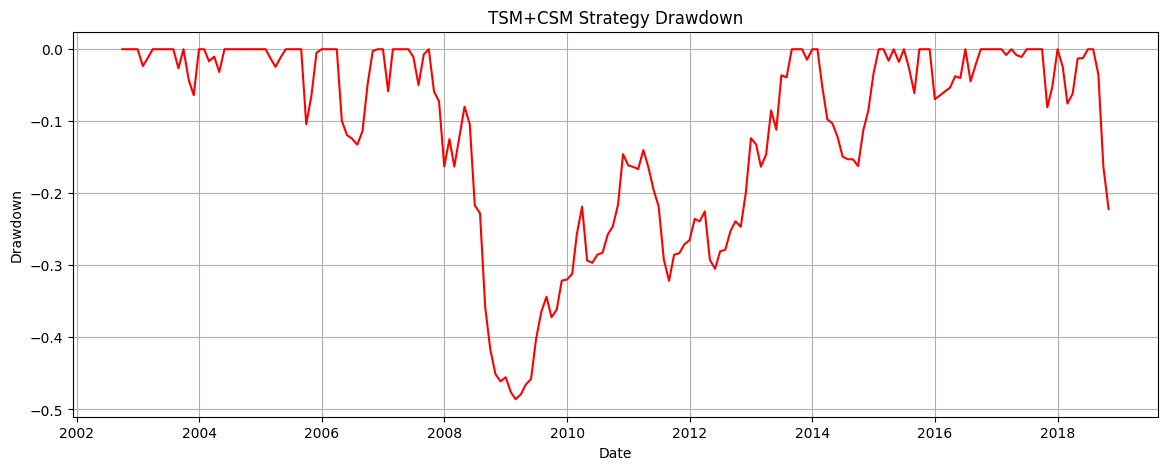

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Re-using parameters from previous steps ---
# Make sure df_tsm and df_csm are available in your session from Step 2.1 and 2.2 runs.
tsm_threshold = 0.0
initial_top_N_csm = 50
final_portfolio_size = 30
rebalance_freq = 'M' # Monthly rebalancing

# --- CORRECTED: Align rebalance dates to where TSM and CSM data actually start ---
# Find the first date where both TSM and CSM data are available
earliest_valid_signal_date = max(df_tsm.index.min(), df_csm.index.min())

# Get all potential rebalancing dates
all_rebalance_dates = pd.date_range(
    start=monthly_returns.index.min(), # Start from the very beginning of monthly_returns
    end=monthly_returns.index.max(),
    freq='ME' # Month End frequency
)

# Filter rebalance_dates to only include actual monthly periods present in monthly_returns
rebalance_dates = all_rebalance_dates[all_rebalance_dates.isin(monthly_returns.index)]

# Further filter rebalance_dates to start only when valid signals (TSM/CSM) are available
rebalance_dates = rebalance_dates[rebalance_dates >= earliest_valid_signal_date]


print(f"Selected {len(rebalance_dates)} rebalancing dates based on frequency '{rebalance_freq}'.")
print(f"True strategy start date (based on signal availability): {earliest_valid_signal_date.strftime('%Y-%m-%d')}")
print("First 5 rebalancing dates:", rebalance_dates[:5].tolist())
print("Last 5 rebalancing dates:", rebalance_dates[-5:].tolist())


# Initialize DataFrame to store strategy returns
# CORRECTED: Use the filtered rebalance_dates as index
strategy_returns = pd.DataFrame(index=rebalance_dates)

# Variable to log selected tickers for the first few periods
selected_holdings_log = {}
max_print_holdings = 10 # Print holdings for the first 10 successful rebalances


print("\n--- Portfolio Holdings at Each Rebalance (First few periods) ---")

# Loop through each rebalancing date to construct and track portfolio
for i in range(len(rebalance_dates)):
    current_rebalance_date = rebalance_dates[i]

    # Determine the next rebalance date (for holding period returns)
    # Handle the very last rebalance date where there is no 'next_month'
    next_month = None
    if i + 1 < len(rebalance_dates):
        next_month = rebalance_dates[i+1]
    else:
        # For the very last rebalance date, we'll hold until the end of monthly_returns data
        pass


    # Get TSM and CSM values for the current rebalance date
    # Ensure to drop NaNs at the stock level for each metric first
    # This .loc call should now be safe because rebalance_dates are aligned
    current_tsm = df_tsm.loc[current_rebalance_date].dropna()
    current_csm = df_csm.loc[current_rebalance_date].dropna()

    # Combine TSM and CSM for stocks that have both valid metrics
    valid_signals = pd.DataFrame({
        'TSM': current_tsm,
        'CSM': current_csm
    }).dropna() # Drop rows where either TSM or CSM is NaN

    # --- TSM Filter (First Screen) ---
    # Select stocks with positive TSM (or TSM > tsm_threshold)
    tsm_filtered_stocks = valid_signals[valid_signals['TSM'] > tsm_threshold]

    if len(tsm_filtered_stocks) < final_portfolio_size:
        if len(selected_holdings_log) < max_print_holdings:
            print(f"  {current_rebalance_date.strftime('%Y-%m-%d')}: Not enough stocks ({len(tsm_filtered_stocks)}) after TSM filter. Skipping.")
        strategy_returns.loc[current_rebalance_date, 'strategy'] = np.nan # Mark as NaN for this period
        continue

    # --- CSM Filter (Second Screen) ---
    # From TSM-filtered stocks, rank by CSM and select top N
    csm_ranked_stocks = tsm_filtered_stocks.sort_values('CSM', ascending=False)
    
    # Take the initial_top_N_csm from this list
    initial_csm_selection = csm_ranked_stocks.head(initial_top_N_csm)

    # --- Final Portfolio Selection ---
    # Enforce final_portfolio_size
    final_portfolio_selection = initial_csm_selection.head(final_portfolio_size)
    
    # Ensure we actually have stocks selected for the final portfolio
    if final_portfolio_selection.empty:
        if len(selected_holdings_log) < max_print_holdings:
            print(f"  {current_rebalance_date.strftime('%Y-%m-%d')}: No stocks left after final selection. Skipping.")
        strategy_returns.loc[current_rebalance_date, 'strategy'] = np.nan
        continue

    # Log selected tickers for display
    if len(selected_holdings_log) < max_print_holdings:
        print(f"  {current_rebalance_date.strftime('%Y-%m-%d')}: Selected {len(final_portfolio_selection)} stocks:")
        print(f"    {final_portfolio_selection.index.tolist()}")
        selected_holdings_log[current_rebalance_date] = final_portfolio_selection.index.tolist() # Store for later review


    # --- Calculate Portfolio Returns for the Holding Period ---
    if next_month is not None:
        # Get the returns for the next month for the selected stocks
        # Check if next_month is actually in monthly_returns index, as rebalance_dates might extend slightly beyond last valid monthly_returns
        if next_month in monthly_returns.index:
            holding_period_returns = monthly_returns.loc[next_month, final_portfolio_selection.index]
            # Calculate equal-weighted portfolio return (mean will handle NaNs if some stocks are missing)
            portfolio_return = holding_period_returns.mean()
            strategy_returns.loc[current_rebalance_date, 'strategy'] = portfolio_return
        else:
            strategy_returns.loc[current_rebalance_date, 'strategy'] = np.nan # No valid next month returns
    else:
        # Last rebalance date, no next month to calculate returns for
        strategy_returns.loc[current_rebalance_date, 'strategy'] = np.nan


# Drop any rows where strategy_returns ended up being NaN (e.g., due to filtering or last month)
strategy_returns = strategy_returns.dropna(how='any')

print("\n--- Portfolio Construction Complete! ---")
print(f"Total rebalancing periods with selected portfolios: {len(strategy_returns)}")
print("\n--- Preview of Strategy Returns ---")
print(strategy_returns.head())
print(strategy_returns.tail())


# --- Benchmark and Performance Calculation ---
# The benchmark needs to be aligned to the actual start/end dates of the strategy returns
benchmark_returns = monthly_returns.mean(axis=1).loc[strategy_returns.index]
strategy_returns['benchmark'] = benchmark_returns

# Define the performance_stats function (ensure it's the CORRECTED version)
# Copying it here for self-contained execution, if it's not globally defined.
def performance_stats(returns, periods_per_year=12):
    returns = returns.dropna()
    if returns.empty:
        return {'CAGR': np.nan, 'Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan}
    
    cumulative = (1 + returns).cumprod()
    total_years = len(returns) / periods_per_year 
    
    cagr = cumulative.iloc[-1] ** (1 / total_years) - 1 if total_years > 0 else np.nan
    vol = returns.std() * np.sqrt(periods_per_year)
    
    sharpe = cagr / vol if vol != 0 and not np.isnan(cagr) else np.nan
    
    roll_max = cumulative.cummax()
    drawdown = (cumulative - roll_max) / roll_max
    max_dd = drawdown.min()
    
    return {'CAGR': cagr, 'Volatility': vol, 'Sharpe Ratio': sharpe, 'Max Drawdown': max_dd}

strategy_stats = performance_stats(strategy_returns['strategy'])
benchmark_stats = performance_stats(strategy_returns['benchmark'])

print(f"\n--- Performance Summary (TSM+CSM Strategy) ---")
print("Strategy Performance:")
for k, v in strategy_stats.items():
    print(f"{k}: {v:.2%}")

print("\nBenchmark Performance (aligned to strategy):")
for k, v in benchmark_stats.items():
    print(f"{k}: {v:.2%}")

# --- Plotting ---
strategy_cum = (1 + strategy_returns['strategy']).cumprod()
benchmark_cum = (1 + strategy_returns['benchmark']).cumprod()

plt.figure(figsize=(14,7))
plt.plot(strategy_cum, label='TSM+CSM Strategy')
plt.plot(benchmark_cum, label='Benchmark')
plt.title('Cumulative Returns: TSM+CSM Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
drawdown_strategy = (strategy_cum / strategy_cum.cummax()) - 1
plt.plot(drawdown_strategy, color='red')
plt.title('TSM+CSM Strategy Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()